<a href="https://githubtocolab.com/borislevant/python4ml/blob/main/regression.ipynb" target="_parent"><img src="./img/colab-badge.svg" alt="Open in Colab"/></a>

# Advanced Topics in Regression & Classification

[![scikit-learn logo](./img/scikit-learn-logo-small.png)](https://scikit-learn.org/stable/)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn import neighbors

%matplotlib inline


## Multiple variables regression

We get back to the problem of predicting the price of the Diamonds. A dataset *Diamonds* containing the prices and other attributes of almost 54,000 diamonds. The variables are as follows
* **Carat** : Carat weight of the Diamond.
* **Cut** : Describe cut quality of the diamond.
    * Quality in increasing order Fair, Good, Very Good, Premium, Ideal .
* **Color** : Color of the Diamond.
    * With D being the best and J the worst.
* **Clarity** : Diamond Clarity refers to the absence of the Inclusions and Blemishes.
    * (In order from Best to Worst, FL = flawless, I3= level 3 inclusions) FL, IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3
* **Depth** : The Height of a Diamond, measured from the Culet to the table, divided by its average Girdle Diameter.
* **Table** : The Width of the Diamond's Table expressed as a Percentage of its Average Diameter.
* **Price** : the Price of the Diamond.
* **X** : Length of the Diamond in mm.
* **Y** : Width of the Diamond in mm.
* **Z** : Height of the Diamond in mm.

*Qualitative Features (Categorical)* : Cut, Color, Clarity.

*Quantitative Features (Numerical)* : Carat, Depth , Table , Price , X , Y, Z.

**Price** is the Target Variable (in other words Dependant variable)


In [2]:
#dfd = sns.load_dataset('diamonds')
dfd = pd.read_csv('./data/diamonds.csv')
dfd.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


First of all, let's check for the NaN values, to make sure all the values are valid. The function *isnull* returns the indexes of the NaN values in each column of the DataFrame. Afterwards, *sum* counts those values. It turns out that there is no NaN in the dataset

In [3]:
dfd.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [4]:
dfd.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Looking carefully at the description of the data, we observe that there are $0$ values for the columns $x$, $y$, $z$. It's clearly not possible, so let's clean those outliers from the data

In [5]:
dfd = dfd[(dfd[['x','y','z']] != 0).all(axis=1)]
dfd.describe()


,carat,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,0.473795,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Each diamond is defined by it's size ($x$, $y$, $z$), but in fact what is important is actually the volume of the diamond. Let's add the new feature to the DatFrame:

<AxesSubplot:xlabel='volume', ylabel='Count'>

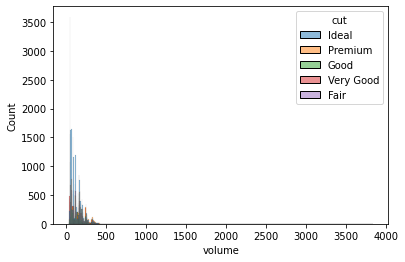

In [6]:
dfd['volume'] = dfd.x * dfd.y * dfd.z
sns.histplot(data=dfd, x="volume", hue="cut")


Let's check the $R^2$ correlation between all the features. For that we will use the method *corr* of the DataFrame, that computes the correlation between all the numerical columns of the DataFrame. As the parameter *name* we pass *pearson* - which stands for the ususal $R^2$. 

To display the correlation matrix, we use the command *heatmap* of the *seaborn* package

<AxesSubplot:>

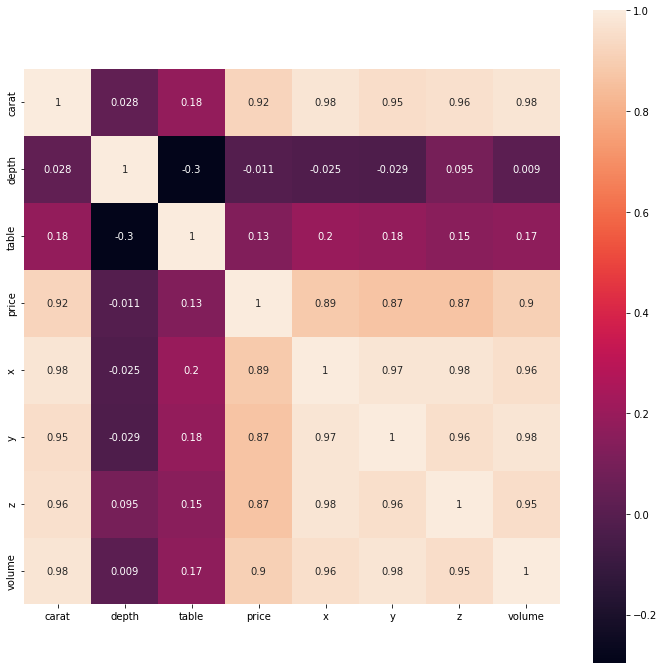

In [7]:
corr_matrix = dfd.corr(method='pearson')
plt.figure(figsize = (12, 12))
sns.heatmap(data=corr_matrix, square=True , annot=True, cbar=True)


Indeed, we observe that the price of the diamond has a high correlation to the size, especially volume, and the amount of carats

Now, let's train the model on the numerical features

In [8]:
Xd = dfd.loc[:, ['carat', 'depth', 'x', 'y', 'z', 'volume']].values
yd = dfd.loc[:, 'price'].values

knn_reg_model_numeric = neighbors.KNeighborsRegressor()
knn_reg_model_numeric.fit(Xd, yd)
print("R^2: {:.4f}".format(knn_reg_model_numeric.score(Xd, yd)))
yd_pred = knn_reg_model_numeric.predict(Xd)


R^2: 0.9117


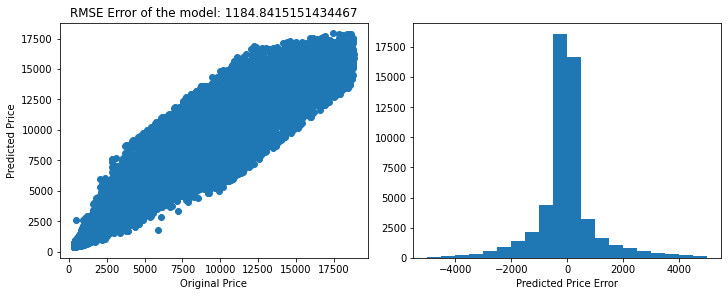

In [9]:
from sklearn import metrics

def plot_results(y, y_pred):
    rmse = metrics.mean_squared_error(y, y_pred)**0.5
    idx = (((y-y_pred)<5000) & ((y-y_pred)>-5000))
    y = y[idx]
    y_pred = y_pred[idx]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 4))
    ax[0].scatter(y, y_pred)
    ax[0].set_xlabel('Original Price')
    ax[0].set_ylabel('Predicted Price')
    ax[0].set_title(f'RMSE Error of the model: {rmse}')
    ax[1].hist(y-y_pred, bins=20)
    ax[1].set_xlabel('Predicted Price Error')

plot_results(yd, yd_pred)


### Categorical variables

Until now we built the model on the numerical variables. However, we see that some of the data: variables *cut*, *color* and *clarity* are in the format of string - Categorical variables. In order to take them into account we need to turn them into numbers. There are few possibilities to do it. We will use one of them that assigns each possible values of the variable a positive integer number.

First let's see the possible values of the variables. To do it, we will use the finction *unique()* of the DataFrame

In [10]:
dfd['cut'].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

Now we can just manually change the values to the numerical

In [11]:
dfd['cut'].replace({'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}, inplace=True)

However, there is a faster way to do it for all the Categorical variables, using the *OrdinalEncoder* from the *preprocessing* package of scikit-learn

In [12]:
from sklearn import preprocessing
oe = preprocessing.OrdinalEncoder()
dfd[['cut', 'color', 'clarity']] = oe.fit_transform(dfd.loc[:, ['cut', 'color', 'clarity']].values)

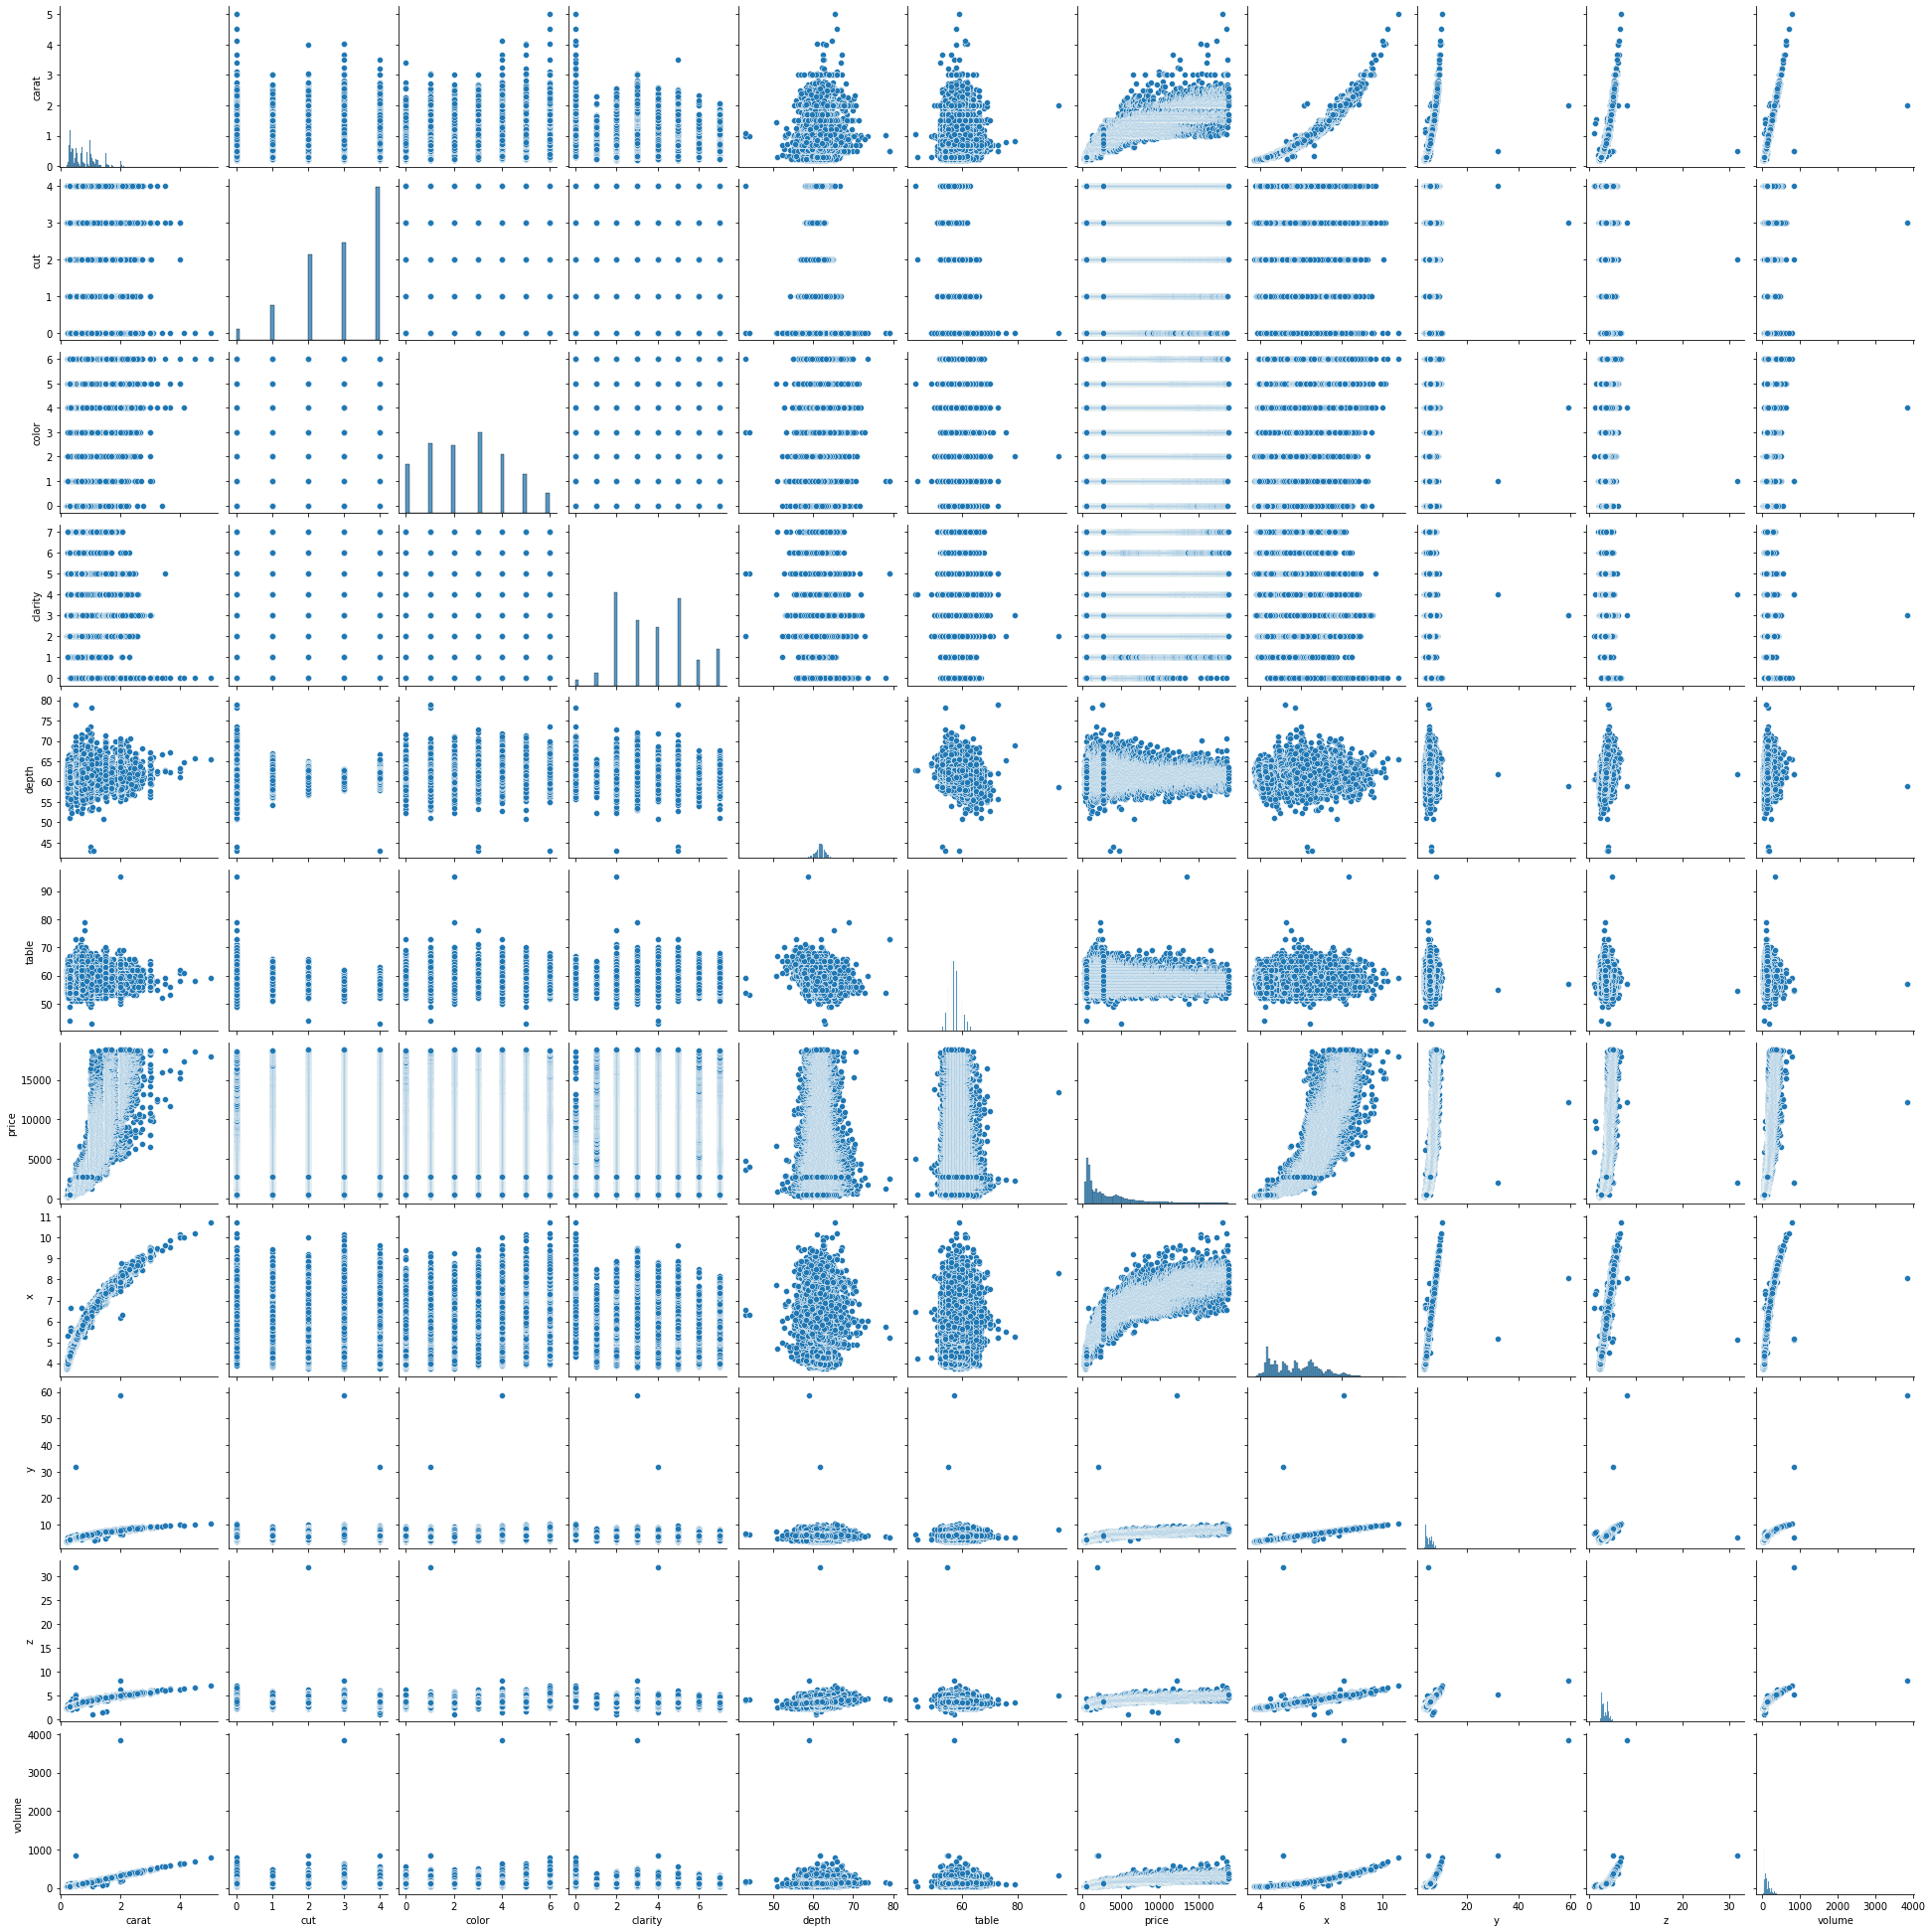

In [13]:
sns.pairplot(dfd)

In [14]:
Xd = dfd.loc[:, ['carat', 'cut', 'color', 'clarity', 'depth', 'x', 'y', 'z', 'volume']].values
yd = dfd.loc[:, 'price'].values

knn_reg_model = neighbors.KNeighborsRegressor()
knn_reg_model.fit(Xd, yd)
print("R^2: {:.4f}".format(knn_reg_model.score(Xd, yd)))
yd_pred_all = knn_reg_model.predict(Xd)

R^2: 0.9686


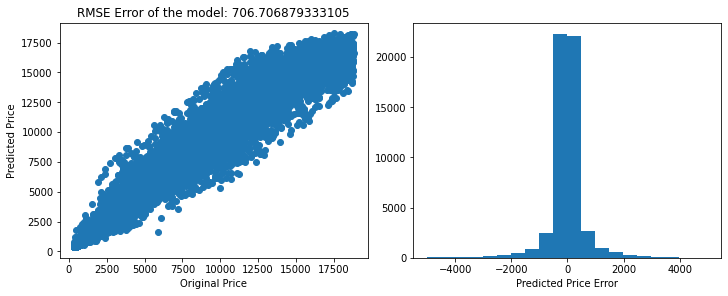

In [15]:
plot_results(yd, yd_pred_all)

### Normalizing the features

It's very important to normalize the features to improve the performance of the `kNN-Regression`. To do it, we used previously the `StandardScaler` object of the `sklearn` package. However, today we will learn another possibility to do it with Pandas. We use the Z-scaling, rescaling the data to zero-mean and STD=1
$$
X = \frac{X - mean(X)}{std(X)}
$$


In [16]:
feature_cols = ['carat', 'cut', 'color', 'clarity', 'depth', 'x', 'y', 'z', 'volume']
dfd_scaled = dfd.copy()
dfd_scaled[feature_cols] = (dfd_scaled[feature_cols] - dfd_scaled[feature_cols].mean()) / dfd_scaled[feature_cols].std()


Now we can observe the differece between the original data and the re-normalized one

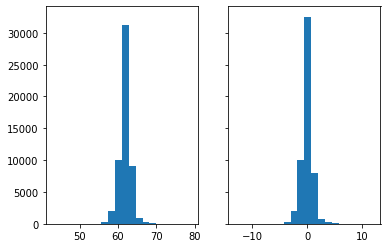

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].hist(dfd.depth, bins=20)
ax[1].hist(dfd_scaled.depth, bins=20)
plt.show()

In [18]:
Xd_scaled = dfd_scaled.loc[:, ['carat', 'cut', 'color', 'clarity', 'depth', 'x', 'y', 'z', 'volume']].values
yd_scaled = dfd_scaled.loc[:, 'price'].values

knn_reg_model = neighbors.KNeighborsRegressor()
knn_reg_model.fit(Xd_scaled, yd_scaled)
print("R^2: {:.4f}".format(knn_reg_model.score(Xd_scaled, yd_scaled)))
yd_pred_scaled_all = knn_reg_model.predict(Xd_scaled)

R^2: 0.9807


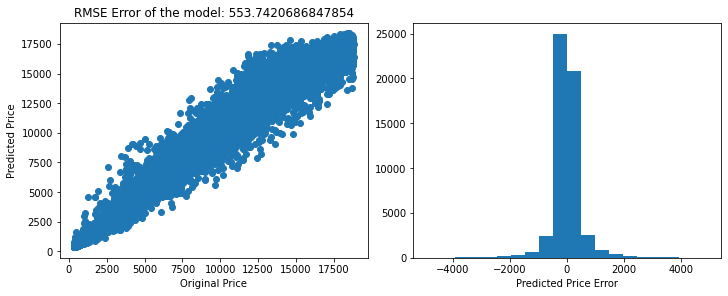

In [19]:
plot_results(yd_scaled, yd_pred_scaled_all)

We observe that the results of the regression improve significantly with Normalized features

### Generalization: train/test

After we built the model, we can now check how our model can generalize. In order to do it, we will split the data into train and test using the function from the *model_selection* package of *scikit-learn*. Note that we split the data $80%$ train and $20%$ test randomly. We also specify the *random_state* to be able to reproduce the results


In [20]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(Xd_scaled, yd_scaled, test_size=0.2, random_state=66)


Train result: R^2: 0.9792
Test result: R^2: 0.9698


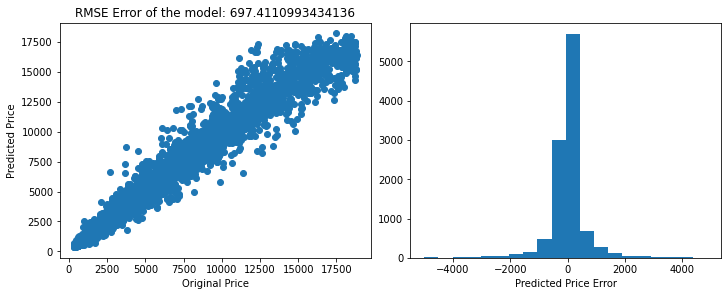

In [21]:
lin_model = neighbors.KNeighborsRegressor()
lin_model.fit(X_train, y_train)
y_pred_test = lin_model.predict(X_test)

print("Train result: R^2: {:.4f}".format(lin_model.score(X_train, y_train)))
print("Test result: R^2: {:.4f}".format(lin_model.score(X_test, y_test)))
plot_results(y_test, y_pred_test)

Please, observe that our model has a good generalization. Since the error and $R^2$ on train and test data are almost the same

Please, note that we improved the model significantly (from error 1343 to 697). We will try to improve it even further.


### Cross-validation

The kNN regression has many `hyper-parameters` and we would like to tune them. The `hyper-parameters` are parameters of the model itself that we can play with:

* **n_neighbors**: Decide the best k based on the values we have computed earlier.
* **weights**: Check whether adding weights to the data points is beneficial to the model or not. 'uniform' assigns no weight, while 'distance' weighs points by the inverse of their distances meaning nearer points will have more weight than the farther points.
* **metric**: The distance metric to be used will calculating the similarity.


In [50]:
from sklearn.model_selection import GridSearchCV

grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform', 'distance'],
               'metric' : ['minkowski', 'euclidean', 'manhattan']}
gs = GridSearchCV(neighbors.KNeighborsRegressor(), grid_params, 
                  scoring='neg_mean_absolute_error', cv=10)


The class `GridSearchCV` performs **k-fold cross-validation** - that's where the **CV** comes from. For example, in our casae we run the **10-fold** cross-validation. The process divides the data into 10 groups, each time training on 9, and testing the performance on the test set in the following way

![](./img/k-fold.jpg)

For each set of parameters defined by the `grid_params` - we execute the procedure 10 times. We estimate the performance of the model by measuring the **neg_mean_absolute_error** - the value passed to the `scoring` parameter of the constructor

The next cell executes the Cross-Validation loop - might take a lot of time

In [45]:
g_res = gs.fit(Xd_scaled, yd_scaled)


After finishing the loop, we can extract the best score and the best parameters for the model through this object members

In [53]:
df_cv = pd.DataFrame(g_res.cv_results_)
df_cv.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.209132,0.026162,0.229310,0.052810,minkowski,5,uniform,"{'metric': 'minkowski', 'n_neighbors': 5, 'wei...",-555.660052,-576.879785,...,-1337.614763,-2448.082864,-522.405749,-142.897255,-209.577745,-283.292470,-371.336832,-719.329866,660.360445,28
1,0.199221,0.010577,0.234419,0.050226,minkowski,5,distance,"{'metric': 'minkowski', 'n_neighbors': 5, 'wei...",-537.297500,-565.572140,...,-1303.896509,-2422.877716,-514.846230,-145.034397,-204.421044,-276.234744,-363.351999,-707.589562,652.651233,16
2,0.198416,0.013638,0.270225,0.078499,minkowski,7,uniform,"{'metric': 'minkowski', 'n_neighbors': 7, 'wei...",-553.674094,-574.060513,...,-1357.502967,-2418.876961,-525.093790,-141.209278,-206.661085,-284.439487,-366.780256,-716.733478,655.194048,20
3,0.207278,0.010399,0.277541,0.063449,minkowski,7,distance,"{'metric': 'minkowski', 'n_neighbors': 7, 'wei...",-534.389104,-559.382362,...,-1313.415433,-2393.656518,-517.575887,-143.225347,-200.615829,-275.591135,-358.033933,-702.202309,646.707867,7
4,0.198418,0.028475,0.270230,0.064138,minkowski,9,uniform,"{'metric': 'minkowski', 'n_neighbors': 9, 'wei...",-560.466123,-570.212887,...,-1375.986379,-2395.393361,-533.625309,-139.675528,-207.959343,-285.309141,-367.415739,-716.921021,650.553325,23


Please, note that the accuracy of each fold appears in the separate column. There are also columns of the mean and STD of the accuracy for each combination of the parameters. Let's examine it:

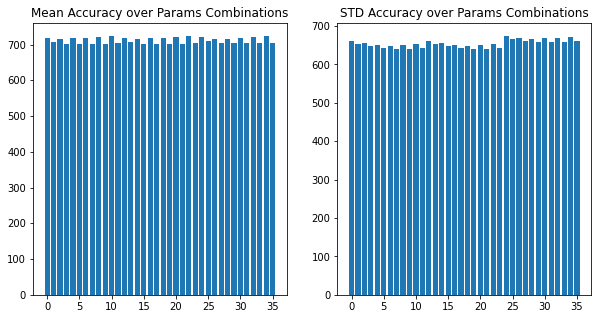

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].bar(range(df_cv.shape[0]), -df_cv.mean_test_score.values)
ax[0].set_title('Mean Accuracy over Params Combinations')
ax[1].bar(range(df_cv.shape[0]), df_cv.std_test_score.values)
ax[1].set_title('STD Accuracy over Params Combinations')
plt.show()

The best configuration of parameters is chosen according to the best mean

In [46]:
g_res.best_score_, g_res.best_params_

(-700.1921951740661,
 {'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'distance'})

Now we are ready to train the model with the best parameters set

Train result: R^2: 1.0000
Test result: R^2: 0.9712


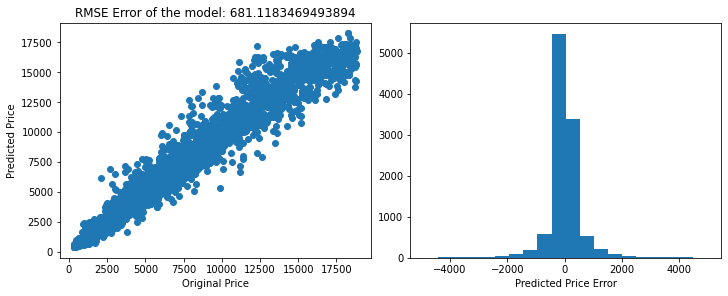

In [58]:
lin_model = neighbors.KNeighborsRegressor(metric='minkowski', n_neighbors=11, weights='distance')
lin_model.fit(X_train, y_train)
y_pred_test = lin_model.predict(X_test)

print("Train result: R^2: {:.4f}".format(lin_model.score(X_train, y_train)))
print("Test result: R^2: {:.4f}".format(lin_model.score(X_test, y_test)))
plot_results(y_test, y_pred_test)

### Overfit & Features importance

Let's observe the importance of checking the perfomance of the model on the test set. Please, note that when the performance of the model on the train data is almost perfect - once we check it on the same data we trained on, we get almost x10 times better perfromance:

In [119]:
def plot_results_train_vs_test(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    err_train = metrics.mean_squared_error(y_train_pred, y_train)**0.5
    err_test = metrics.mean_squared_error(y_test_pred, y_test)**0.5
    
    fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 4))
    ax[0].scatter(y_train, y_train_pred)
    ax[0].set_xlabel('Original Price')
    ax[0].set_ylabel('Predicted Price')
    ax[0].set_title(f'Train RMSE Error of the model: {err_train}')
    ax[1].scatter(y_test, y_test_pred)
    ax[1].set_xlabel('Predicted Price Error')
    ax[1].set_title(f'Test RMSE Error of the model: {err_test}')


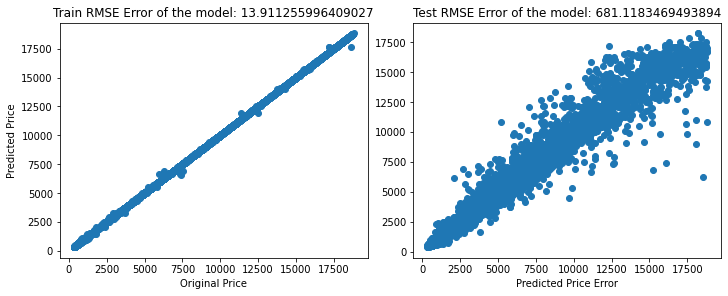

In [120]:
Xd_scaled = dfd_scaled.loc[:, ['carat', 'cut', 'color', 'clarity', 'depth', 'x', 'y', 'z', 'volume']].values
yd_scaled = dfd_scaled.loc[:, 'price'].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(Xd_scaled, yd_scaled, test_size=0.2, random_state=66)

knn_reg_model = neighbors.KNeighborsRegressor(metric='minkowski', n_neighbors=11, weights='distance')
knn_reg_model.fit(X_train, y_train)
plot_results_train_vs_test(knn_reg_model, X_train, X_test, y_train, y_test)


We can observe from the correlation matrix, that the parameter `depth` is less corrlative to the `price`. Let's try to remove it

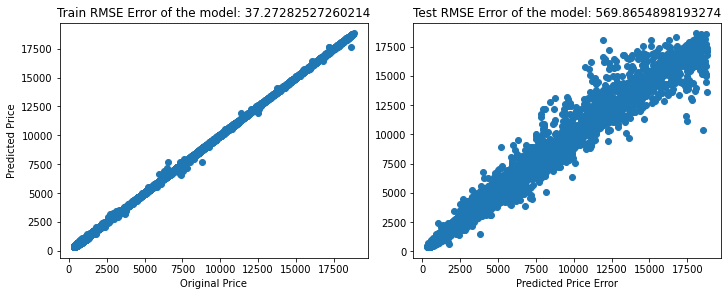

In [124]:
Xd_scaled = dfd_scaled.loc[:, ['carat', 'cut', 'color', 'clarity', 'volume']].values
yd_scaled = dfd_scaled.loc[:, 'price'].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(Xd_scaled, yd_scaled, test_size=0.2, random_state=66)

knn_reg_model = neighbors.KNeighborsRegressor(metric='minkowski', n_neighbors=11, weights='distance')
knn_reg_model.fit(X_train, y_train)
plot_results_train_vs_test(knn_reg_model, X_train, X_test, y_train, y_test)


We see that training the model without `depth` and the individual size parameters (x, y, z) improves the results substantially

### Excercise 1

Load the data in the CSV format from the file './data/carmpg.csv'. The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes (from 1993). We requisted
* Clean the NaN values
* Perform a basic data analysis: show the data and main variables dependencies
* Turn the categorical variables into the numerical
* Normalize the features
* Train the kNN regression model predicting the MPG consumption of the cars based on the paramters
* Choose the optimal paramters of the regressor by performing the cross-validation


# References

- Scikit-learn [supervised learning tutorial](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html).
- [Tuning meta-parameters](http://scikit-learn.org/stable/modules/grid_search.html#grid-search) with cross validation.

# Futher exercise

- [Regression with a linear model](../exercises/linear-model.ipynb)
- [Classification with a logistic model](../exercises/logistic-tennis.ipynb)